#  Exploración y Segmentación de Cafeterías en Vecindarios de Toronto: Un enfoque basado en Ciencia de Datos

## 1. Descripción del Problema y Antecedentes:


En este proyecto, se analizará la distribución de cafeterías en los vecindarios de Toronto. Se buscará identificar qué vecindarios tienen la mayor concentración de cafeterías y agruparlos en clusters para facilitar la comprensión de los datos. Los resultados podrían ser útiles para inversionistas que estén interesados en abrir una nueva cafetería en Toronto o para cualquier persona interesada en entender la distribución de estos negocios en la ciudad.

## 2. Descripción

Los datos utilizados en este proyecto provienen de dos fuentes principales: la página de Wikipedia con la lista de códigos postales de Canadá y el archivo CSV que contiene las coordenadas geográficas de cada código postal. Además, se utiliza la API de Foursquare para obtener información sobre las cafeterías y otros lugares relacionados en cada vecindario.

## 3. Metodología

Los datos utilizados en este proyecto provienen de dos fuentes principales: la página de Wikipedia con la lista de códigos postales de Canadá y el archivo CSV que contiene las coordenadas geográficas de cada código postal. Además, se utiliza la API de Foursquare para obtener información sobre las cafeterías y otros lugares relacionados en cada vecindario.

### 3.1. Datos

A continuación, se combina el DataFrame original con otro DataFrame que contiene las coordenadas geográficas de cada código postal. Con estos datos, se crea un mapa interactivo de downtown de Toronto utilizando la biblioteca Folium para visualizar los vecindarios.

In [57]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import requests
import folium
import geocoder
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
from bs4 import BeautifulSoup

# Obtener los datos de Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, "lxml")

# Procesar los datos y guardarlos en una lista
table_contents = []
table = soup.find("table")
for row in table.findAll("td"):
    cell = {}
    if row.span.text == "Not assigned":
        pass
    else:
        cell["CódigoPostal"] = row.p.text[:3]
        cell["Municipio"] = (row.span.text).split("(")[0]
        cell["Vecindario"] = (((((row.span.text).split("(")[1]).strip(")")).replace(" /", ",")).replace(")", " ")).strip(" ")
        table_contents.append(cell)

# Convertir la lista en un DataFrame
df = pd.DataFrame(table_contents)

# Limpiar y reemplazar algunos nombres de Municipio
df["Municipio"] = df["Municipio"].replace({"Downtown TorontoStn A PO Boxes25 The Esplanade": "Downtown Toronto Stn A",
                                           "East TorontoBusiness reply mail Processing Centre969 Eastern": "East Toronto Business",
                                           "EtobicokeNorthwest": "Etobicoke Northwest",
                                           "East YorkEast Toronto": "East York/East Toronto",
                                           "MississaugaCanada Post Gateway Processing Centre": "Mississauga"})

# Mostrar el DataFrame
df


,CódigoPostal,Municipio,Vecindario
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [58]:
coordinates_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv"
coordinates_df = pd.read_csv(coordinates_url)

# Renombrar la columna 'Postal Code' a 'CódigoPostal'
coordinates_df.rename(columns={"Postal Code": "CódigoPostal"}, inplace=True)

# Combinar el DataFrame original 'df' con el DataFrame de coordenadas 'coordinates_df' usando la columna 'CódigoPostal'
df_with_coordinates = pd.merge(df, coordinates_df, on="CódigoPostal")

df_with_coordinates


,CódigoPostal,Municipio,Vecindario,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [107]:
address = 'Downtown Toronto'

geolocator = Nominatim(user_agent="toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

downtown_data = df_with_coordinates[df_with_coordinates['Municipio'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_data.head()

map_downtown = folium.Map(location=[latitude, longitude], zoom_start=11)

# añadir los marcadores al mapa
for lat, lng, label in zip(downtown_data['Latitude'], downtown_data['Longitude'], downtown_data['Vecindario']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  
    
map_downtown

The geograpical coordinate of Downtown Toronto are 43.6583244, -79.37892515687948.


### 3.2. API de Foursquare y K-Means Clustering

Se emplea la API de Foursquare para obtener información sobre las cafeterías en cada vecindario y se crea otro DataFrame con todos los lugares relevantes. Posteriormente, se realiza un análisis de frecuencia para identificar las cafeterías más comunes en cada vecindario y se aplican algoritmos de clustering (K-means) para agrupar los vecindarios según la concentración de cafeterías.

In [60]:
CLIENT_ID = 'AMSKZLPOPX4CMUS210Q3ISC3PJFDEDGHIC05JIX4YR2F1XYT'
CLIENT_SECRET = '2DCKLFRT2NRV0J3AZ03LAU1QCDI5W33SGHUG32NPUYZDP4L3'
VERSION = '20180605'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AMSKZLPOPX4CMUS210Q3ISC3PJFDEDGHIC05JIX4YR2F1XYT
CLIENT_SECRET:2DCKLFRT2NRV0J3AZ03LAU1QCDI5W33SGHUG32NPUYZDP4L3


In [61]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=30, query='cafe'):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
       # print(name)
        
        #url = f'https://api.foursquare.com/v3/places/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={latitude},{longitude}&v={VERSION}&mode=closest&radius={radius}&limit={limit}'
        url = f'https://api.foursquare.com/v3/places/search?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={lat},{lng}&v={VERSION}&q=*&radius={radius}&limit={limit}'
        headers = {
            "Accept": "application/json",
            "Authorization": "fsq3bbr+rptlS0dG1n6D8NZHF+UtGIYdioKP3Ly02BGVAZc="
        }
        
        response = requests.request("GET", url, headers=headers).json()
        venues_list.append(response)

    return venues_list

downtown_venues = getNearbyVenues(names=downtown_data['Vecindario'],
                                 latitudes=downtown_data['Latitude'],
                                 longitudes=downtown_data['Longitude'])

all_venues = []

# Iterar sobre las respuestas JSON de Foursquare
for venue_data in downtown_venues:
    # Extraemos los lugares de la respuesta JSON
    venue = venue_data['results']
    
    # Transformamos los lugares en un DataFrame
    venue_df = pd.json_normalize(venue)

    # Agregar el DataFrame actual de lugares a la lista de todos los lugares
    all_venues.append(venue_df)

# Concatenar todos los DataFrames de lugares en uno solo
all_venues_df = pd.concat(all_venues, ignore_index=True)

def extract_main_category(categories_list):
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

all_venues_df['main_category'] = all_venues_df['categories'].apply(extract_main_category)
all_venues_df.drop('categories', axis=1, inplace=True)

print(all_venues_df.shape)
#print(downtown_venues)
all_venues_df
all_venues_df.info()
all_venues_df.describe()
                    

(493, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fsq_id                         493 non-null    object 
 1   chains                         493 non-null    object 
 2   distance                       493 non-null    int64  
 3   link                           493 non-null    object 
 4   name                           493 non-null    object 
 5   timezone                       454 non-null    object 
 6   geocodes.main.latitude         493 non-null    float64
 7   geocodes.main.longitude        493 non-null    float64
 8   geocodes.roof.latitude         480 non-null    float64
 9   geocodes.roof.longitude        480 non-null    float64
 10  location.address               483 non-null    object 
 11  location.country               493 non-null    object 
 12  location.cross_street          431 non-n

,distance,geocodes.main.latitude,geocodes.main.longitude,geocodes.roof.latitude,geocodes.roof.longitude,geocodes.drop_off.latitude,geocodes.drop_off.longitude,geocodes.front_door.latitude,geocodes.front_door.longitude
count,493.000000,493.000000,493.000000,480.000000,480.000000,134.000000,134.000000,3.000000,3.000000
mean,193.265720,43.655611,-79.384003,43.655769,-79.384071,43.661033,-79.385771,43.649668,-79.386654
std,100.234585,0.010844,0.013808,0.010514,0.013886,0.010418,0.016698,0.009950,0.003762
min,4.000000,43.627489,-79.426153,43.627489,-79.426153,43.639626,-79.424494,43.639560,-79.390790
25%,131.000000,43.648262,-79.386152,43.648456,-79.385835,43.653362,-79.400237,43.644776,-79.388263
50%,173.000000,43.653708,-79.381423,43.653752,-79.381437,43.659104,-79.381613,43.649992,-79.385737
75%,243.000000,43.663294,-79.375999,43.663379,-79.376179,43.667549,-79.374173,43.654722,-79.384586
max,504.000000,43.683458,-79.356354,43.683458,-79.356354,43.682757,-79.357143,43.659453,-79.383435


In [62]:
all_venues_df['main_category'].value_counts()


Café                             30
Restaurant                       21
Cafes, Coffee, and Tea Houses    18
Coffee Shop                      16
Pizzeria                         13
                                 ..
Toy / Game Store                  1
Candy Store                       1
Entertainment Service             1
Bicycle Store                     1
Ice Cream Parlor                  1
Name: main_category, Length: 156, dtype: int64

In [63]:
#DataFrame que contiene lugares que pertenecen a las categorías de cafe
relevant_categories = ['Café', 'Coffee Shop', 'Cafes, Coffee, and Tea Houses', 'Bubble Tea Shop']
cafes_and_related_df = all_venues_df[all_venues_df['main_category'].isin(relevant_categories)].reset_index(drop=True)
cafes_and_related_df


,fsq_id,chains,distance,link,name,timezone,geocodes.main.latitude,geocodes.main.longitude,geocodes.roof.latitude,geocodes.roof.longitude,...,geocodes.drop_off.latitude,geocodes.drop_off.longitude,location.address_extended,related_places.children,related_places.parent.fsq_id,related_places.parent.name,geocodes.front_door.latitude,geocodes.front_door.longitude,location.po_box,main_category
0,53b8466a498e83df908c3f21,[],122,/v3/places/53b8466a498e83df908c3f21,Tandem Coffee,America/Toronto,43.653663,-79.361894,43.653663,-79.361894,...,43.653549,-79.361827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Café
1,581258b738fa5bbefe4c0857,[],314,/v3/places/581258b738fa5bbefe4c0857,Dark Horse Espresso Bar,America/Toronto,43.653161,-79.357186,43.653161,-79.357186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coffee Shop
2,4fb13c20e4b011e6f93513c0,[],79,/v3/places/4fb13c20e4b011e6f93513c0,Balzacs Coffee,America/Toronto,43.657799,-79.379195,43.657799,-79.379195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Café
3,5a55078bda5ede6ed9d73a62,[],122,/v3/places/5a55078bda5ede6ed9d73a62,Tokyo Smoke 333 Yonge,America/Toronto,43.657155,-79.381103,43.657155,-79.381103,...,NaN,NaN,NaN,NaN,5a32970da42362290203a9d6,Assembly Chef's Hall,NaN,NaN,NaN,Coffee Shop
4,4b9e7418f964a52032e536e3,[{'id': 'd5713b70-d890-0132-61d3-7a163eb2a6fc'...,182,/v3/places/4b9e7418f964a52032e536e3,Second Cup,America/Toronto,43.655968,-79.380447,43.655968,-79.380447,...,43.655856,-79.380708,Unit D102,NaN,4ad77a12f964a520260b21e3,CF Toronto Eaton Centre,NaN,NaN,NaN,"Cafes, Coffee, and Tea Houses"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,55a63131498e114c3c6d2cd5,[],172,/v3/places/55a63131498e114c3c6d2cd5,McEwan Foods,America/Toronto,43.647327,-79.381176,43.647327,-79.381176,...,NaN,NaN,NaN,NaN,4b9e86dff964a520e6eb36e3,Flight Centre TD Centre,NaN,NaN,NaN,"Cafes, Coffee, and Tea Houses"
65,5b6c842bc36588002c80a934,[],250,/v3/places/5b6c842bc36588002c80a934,Cafe Landwer,America/Toronto,43.648724,-79.385137,43.648724,-79.385137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Café
66,59ecf741da2e006b9e11a3d3,[],193,/v3/places/59ecf741da2e006b9e11a3d3,The Alley,America/Toronto,43.665748,-79.385698,43.665748,-79.385698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bubble Tea Shop
67,4b843f5ef964a5202b2a31e3,[{'id': 'd5719cc0-d890-0132-61d3-7a163eb2a6fc'...,156,/v3/places/4b843f5ef964a5202b2a31e3,Tim Hortons,America/Toronto,43.664746,-79.384041,43.664746,-79.384041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cafes, Coffee, and Tea Houses"


In [64]:
# codificación
downtown_onehot = pd.get_dummies(cafes_and_related_df[['main_category']], prefix="", prefix_sep="")

# añadir la columna de barrio de regreso al dataframe
downtown_onehot['Vecindario'] = downtown_data['Vecindario'] 

# mover la columna de barrio a la primer columna
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]
downtown_onehot.dropna(inplace=True)
downtown_onehot


,Vecindario,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Café,Coffee Shop
0,"Regent Park, Harbourfront",0,0,1,0
1,"Garden District, Ryerson",0,0,0,1
2,St. James Town,0,0,1,0
3,Berczy Park,0,0,0,1
4,Central Bay Street,0,1,0,0
5,Christie,0,0,1,0
6,"Richmond, Adelaide, King",1,0,0,0
7,"Harbourfront East, Union Station, Toronto Islands",0,0,0,1
8,"Toronto Dominion Centre, Design Exchange",0,0,1,0
9,"Commerce Court, Victoria Hotel",0,0,0,1


In [65]:
downtown_grouped = downtown_onehot.groupby('Vecindario').mean().reset_index()
downtown_grouped


,Vecindario,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Café,Coffee Shop
0,Berczy Park,0.0,0.0,0.0,1.0
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.0,1.0
2,Central Bay Street,0.0,1.0,0.0,0.0
3,Christie,0.0,0.0,1.0,0.0
4,Church and Wellesley,0.0,1.0,0.0,0.0
5,"Commerce Court, Victoria Hotel",0.0,0.0,0.0,1.0
6,"First Canadian Place, Underground city",0.0,1.0,0.0,0.0
7,"Garden District, Ryerson",0.0,0.0,0.0,1.0
8,"Harbourfront East, Union Station, Toronto Islands",0.0,0.0,0.0,1.0
9,"Kensington Market, Chinatown, Grange Park",0.0,0.0,0.0,1.0


In [66]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [97]:
num_top_venues =4

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Vecindario']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Vecindario'] = downtown_grouped['Vecindario']

for ind in np.arange(downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Vecindario,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Berczy Park,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
1,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
2,Central Bay Street,Cluster Labels,"Cafes, Coffee, and Tea Houses",Bubble Tea Shop,Café
3,Christie,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
4,Church and Wellesley,Cluster Labels,"Cafes, Coffee, and Tea Houses",Bubble Tea Shop,Café


In [98]:
downtown_grouped = downtown_onehot.groupby('Vecindario').mean().reset_index()
k_clusters = 4
downtown_clustering =downtown_grouped.drop('Vecindario', axis=1)
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(downtown_clustering)
downtown_grouped['Cluster Labels'] = kmeans.labels_
kmeans.labels_[0:10] 
downtown_grouped

,Vecindario,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Café,Coffee Shop,Cluster Labels
0,Berczy Park,0.0,0.0,0.0,1.0,1
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.0,1.0,1
2,Central Bay Street,0.0,1.0,0.0,0.0,2
3,Christie,0.0,0.0,1.0,0.0,0
4,Church and Wellesley,0.0,1.0,0.0,0.0,2
5,"Commerce Court, Victoria Hotel",0.0,0.0,0.0,1.0,1
6,"First Canadian Place, Underground city",0.0,1.0,0.0,0.0,2
7,"Garden District, Ryerson",0.0,0.0,0.0,1.0,1
8,"Harbourfront East, Union Station, Toronto Islands",0.0,0.0,0.0,1.0,1
9,"Kensington Market, Chinatown, Grange Park",0.0,0.0,0.0,1.0,1


/var/folders/k1/0fydw5gj22zd6w311pvdxv30841vsq/T/ipykernel_3025/3275223811.py:6: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k, random_state=0).fit(downtown_clustering)
/var/folders/k1/0fydw5gj22zd6w311pvdxv30841vsq/T/ipykernel_3025/3275223811.py:6: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k, random_state=0).fit(downtown_clustering)
/var/folders/k1/0fydw5gj22zd6w311pvdxv30841vsq/T/ipykernel_3025/3275223811.py:6: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k, random_state=0).fit(downtown_clustering)
/var/folders/k1/0fydw5gj22zd6w311pvdxv30841vsq/T/ipykernel_3025/3275223811.py:6: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_cluste

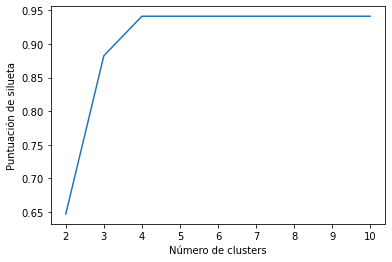

In [95]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt  # Se agrega esta línea para importar la librería de Matplotlib

sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(downtown_clustering)
    silhouette_avg = silhouette_score(downtown_clustering, kmeans.labels_)
    sil_scores.append(silhouette_avg)

plt.plot(range(2, 11), sil_scores)
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de silueta')
plt.show()

### 3.3. Resultados 

Los resultados se visualizan en un mapa interactivo con los clusters identificados por colores diferentes. Además, se presenta una tabla con los vecindarios y sus respectivos clusters.

In [102]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
downtown_merged = downtown_data
downtown_merged = downtown_data.join(neighborhoods_venues_sorted.set_index('Vecindario'), on='Vecindario')
downtown_merged


,CódigoPostal,Municipio,Vecindario,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Cluster Labels,"Cafes, Coffee, and Tea Houses",Bubble Tea Shop,Café
5,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
6,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,3,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Café
7,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
8,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
9,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"


In [108]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# establecer el esquema de color para las agrupaciones
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['Latitude'], downtown_merged['Longitude'], downtown_merged['Vecindario'], downtown_merged['Cluster Labels']):
    try:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
    except IndexError:
        print(f"Error: Invalid cluster index ({cluster}) for {poi} at ({lat}, {lon})")
        continue

        
map_clusters

In [104]:
for cluster_num in range(4):
    print(f"Cluster {cluster_num}:")
    display(downtown_merged.loc[downtown_merged['Cluster Labels'] == cluster_num, downtown_merged.columns[[2] + list(range(5, downtown_merged.shape[1]))]])


Cluster 0:


,Vecindario,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Regent Park, Harbourfront",0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
2,St. James Town,0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
5,Christie,0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
8,"Toronto Dominion Centre, Design Exchange",0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
10,"University of Toronto, Harbord",0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop
13,Rosedale,0,Café,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Coffee Shop


Cluster 1:


,Vecindario,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
1,"Garden District, Ryerson",1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
3,Berczy Park,1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
7,"Harbourfront East, Union Station, Toronto Islands",1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
9,"Commerce Court, Victoria Hotel",1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
11,"Kensington Market, Chinatown, Grange Park",1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
12,"CN Tower, King and Spadina, Railway Lands, Har...",1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"
14,"St. James Town, Cabbagetown",1,Coffee Shop,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses"


Cluster 2:


,Vecindario,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
4,Central Bay Street,2,Cluster Labels,"Cafes, Coffee, and Tea Houses",Bubble Tea Shop,Café
15,"First Canadian Place, Underground city",2,Cluster Labels,"Cafes, Coffee, and Tea Houses",Bubble Tea Shop,Café
16,Church and Wellesley,2,Cluster Labels,"Cafes, Coffee, and Tea Houses",Bubble Tea Shop,Café


Cluster 3:


,Vecindario,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
6,"Richmond, Adelaide, King",3,Cluster Labels,Bubble Tea Shop,"Cafes, Coffee, and Tea Houses",Café


## 4. Conclusiones 

En base a los los resultados de clustering, se han identificado 4 clusters diferentes en el centro de Toronto, cada uno con sus propias características en términos de lugares relacionados con el café.

Cluster 0:
En este cluster, el lugar más común es un Café, seguido de Bubble Tea Shop, Cafes, Coffee, and Tea Houses y Coffee Shop. Esto indica que los vecindarios en este cluster tienen una mayor presencia de cafeterías.

Cluster 1:
En este cluster, el lugar más común es un Coffee Shop, seguido de Bubble Tea Shop, Cafes, Coffee, and Tea Houses y Café. Aquí, los Coffee Shops parecen ser más prevalentes que en el Cluster 0.

Cluster 2:
Este cluster se caracteriza por tener Cafes, Coffee, and Tea Houses como el lugar más común, seguido de Bubble Tea Shop, Café y Coffee Shop. Podría interpretarse como un área con una combinación equilibrada de diferentes tipos de establecimientos relacionados con el café.

Cluster 3:
En el Cluster 3, el lugar más común es un Bubble Tea Shop, seguido de Cafes, Coffee, and Tea Houses, Café y Coffee Shop. Esto sugiere que en estos vecindarios hay una mayor prevalencia de tiendas de Bubble Tea en comparación con los otros clusters.


## 5. Recomendaciones

En base a esta información, podrías recomendar lo siguiente para la ubicación de un café:

1. Si se busca establecer el café en un área donde ya existen muchas cafeterías y una gran cultura del café, el Cluster 0 podría ser una buena opción. Sin embargo, también se podría enfrentar una mayor competencia en estos vecindarios.
2. Si se busca un área donde los Coffee Shops sean más comunes y quieras competir directamente con ellos, se podría considerar el Cluster 1.
3. Si se desea un área con una combinación equilibrada de diferentes tipos de establecimientos relacionados con el café, el Cluster 2 podría ser una opción interesante.
4. Si se desea ubicar tu café en un área con una mayor presencia de Bubble Tea Shops, podrías considerar el Cluster3, aquí, se podrías tener la oportunidad de atraer a clientes que buscan alternativas a las tiendas de Bubble Tea.

Todos estos son puntos de partida y que se recomienda considerar otros factores, como la demografía, el acceso al transporte público, y la renta promedio de la zona, para tomar una decisión con mayor precisión sobre la ubicación de un café o cualquier otro negocio.
